In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.transpiler.passes import Depth
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

import sys
import os

sys.path.append(os.path.abspath("..\\..\\.."))
from objects.FiveQbStabilizerCode import FiveQbStabilizerCodeCircuit
from functions import *


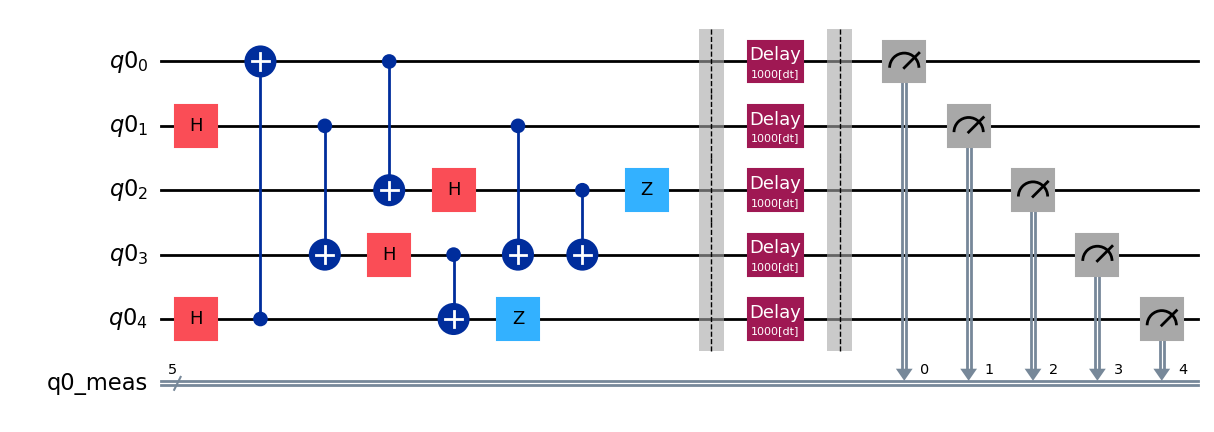

In [3]:


def load_circuit(delay):
    qc = FiveQbStabilizerCodeCircuit(1)

    type = '0'
    qc.encode(type=type)

    qc.delay(delay)
    qc.measure_all()

    return qc

qc = load_circuit(1000)
qc.draw('mpl')



In [4]:
ibm_token = ""
service = QiskitRuntimeService(channel="ibm_quantum", token=ibm_token)
backend = service.backend("ibm_sherbrooke")

In [5]:

phy_qc = qc.physical_circuit
isa_circuit = transpile(phy_qc, backend, scheduling_method="asap", optimization_level=3)
print(f"Circuit Depth: {qc.physical_circuit.depth()}")
print(f"Transpiled Circuit Depth: {isa_circuit.depth()}")
# isa_circuit.draw(output='mpl')



Circuit Depth: 9
Transpiled Circuit Depth: 28


In [6]:
dt = backend.configuration().dt * 10**9
print(f'dt = {round(dt, 3)} ns')

dt = 0.222 ns


In [7]:
# t_array = [2_500, 5_000, 10_000, 20_000, 80_000, 160_000, 320_000]
# t_array = range(0, 21)
# t_array = [t*10_000 for t in t_array]
# t_array = [t*4_000 for t in range(0, 6)]
t_array = [t*90_000 for t in range(0,5)]
print([round(t*dt * 10**(-3),2) for t in t_array])

[0.0, 20.0, 40.0, 60.0, 80.0]


In [8]:

# circuits = []

# for t in t_array:

#     qc = load_circuit(t)

#     isa_circuit = get_transpile(qc.physical_circuit, backend, iterations=100, scheduling_method="asap", optimization_level=3,
#                                 initial_layout=[122, 123, 121, 111, 124]
#                                 )      
#     circuits.append(isa_circuit)

#     print(f"Circuit Depth: {circuits[-1].depth()}")
#     print(f"Delay Duration: {round(t*dt * 10**(-3), 3)} us")
#     print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} us\n")
#     print(get_layout(circuits[-1], 5))

#     # c.draw(output='mpl')

In [10]:
simulation_result = sampler_simulation(qc.physical_circuit, 3200)
extract_simulation_results([simulation_result], type='percentage')

{'q0_meas': [{'00000': 6.5625,
   '00001': 0.0,
   '00010': 0.0,
   '00011': 6.125,
   '00100': 0.0,
   '00101': 6.625,
   '00110': 6.375,
   '00111': 0.0,
   '01000': 0.0,
   '01001': 6.1875,
   '01010': 6.812500000000001,
   '01011': 0.0,
   '01100': 6.5625,
   '01101': 0.0,
   '01110': 0.0,
   '01111': 6.5,
   '10000': 0.0,
   '10001': 5.65625,
   '10010': 5.90625,
   '10011': 0.0,
   '10100': 6.343749999999999,
   '10101': 0.0,
   '10110': 0.0,
   '10111': 5.03125,
   '11000': 6.1875,
   '11001': 0.0,
   '11010': 0.0,
   '11011': 5.75,
   '11100': 0.0,
   '11101': 6.90625,
   '11110': 6.468749999999999,
   '11111': 0.0}]}

In [36]:
sampler = SamplerV2(backend=backend)
shots = 3200
# job = sampler.run(circuits, shots=shots)
# job = service.job('cxjy7an6t010008d0g50') # t_array = [2_500, 5_000, 10_000, 20_000, 80_000, 160_000, 320_000]
# job = service.job('cxk1y7rky7rg008493ng') # kyiv
# job = service.job('cxmygv3ky7rg0084g3kg') # brisbane iteracion 1  <----
# job = service.job('cxmyj0rvw7kg008sq900') # brisbane iteracion 2
# job = service.job('cxmym3g6t010008d7sz0') # brisbane iteracion 3
# job = service.job('cyhbnen9b62g00826jy0') # shots = 3200, t_array = [t*4_000 for t in range(0, 6)]
job = service.job('cz4y23810wx0008bhqwg') # sherbrooke shots = 3200, t_array = [t*90_000 for t in range(0,5)]


pub_result = job.result()


In [37]:
states = get_possible_states(5)
results = extract_results_IBM(pub_result, type='percentage')["q0_meas"]

In [38]:

delays = [round(t*dt/1000) for t in t_array]

In [39]:
valid_states = [s for s in states if sum([int(i) for i in s]) % 2 == 0]

In [40]:
import matplotlib.pyplot as plt
import math

# x = [math.log(d) for d in delays]
x = delays
y = {}
for s in states:
    y[s] = [r[s] for r in results]


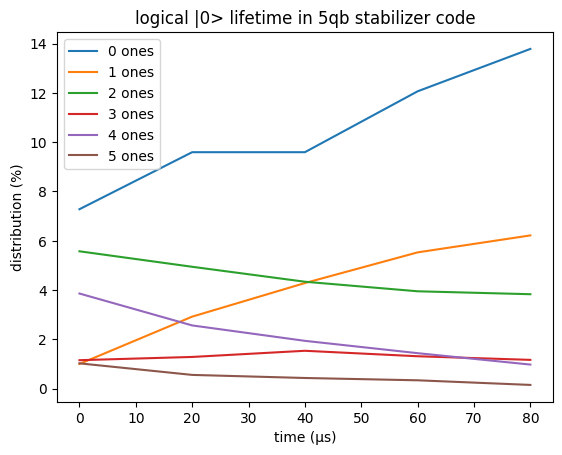

In [41]:

for n in [0,1,2,3,4,5]:

    n_ones_states = [s for s in states if sum([int(i) for i in s]) == n]
    plt.plot(x, [sum([r[s] for s in n_ones_states])/len(n_ones_states) for r in results], label=f"{n} ones")



# Add labels and title
plt.xlabel('time (μs)')
plt.ylabel('distribution (%)')
plt.title('logical |0> lifetime in 5qb stabilizer code')
plt.legend()

# Display the plot
plt.show()

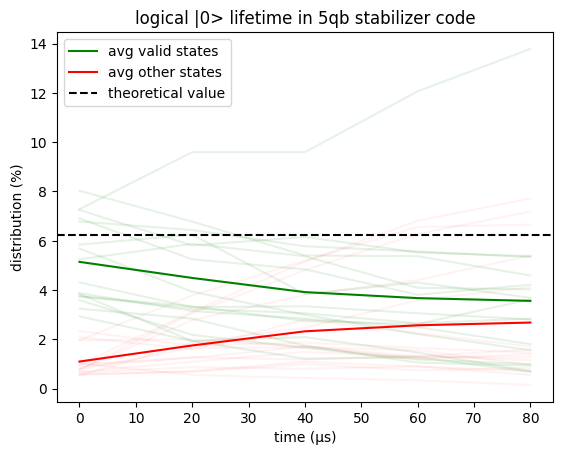

In [42]:
for s in states:
    y[s] = [r[s] for r in results]
    
    if s in valid_states:
        # if s == '00000':
        #     plt.plot(x, y[s], alpha=0.2, color='black')
        #     continue
        plt.plot(x, y[s], alpha=0.1, color='green')
    else:
        plt.plot(x, y[s], alpha=0.05, color='red')


plt.plot(x, [sum([r[s] for s in valid_states])/16 for r in results], label='avg valid states', color='green')
# plt.plot(x, [sum([r[s] for s in valid_states if s != '00000'])/15 for r in results], label='avg valid states', color='black')
plt.plot(x, [sum([r[s] for s in states if s not in valid_states])/16 for r in results], label='avg other states', color='red')

plt.axhline(y=100/16, color='k', linestyle='--', label='theoretical value')
    
# Add labels and title
plt.xlabel('time (μs)')
plt.ylabel('distribution (%)')
plt.title('logical |0> lifetime in 5qb stabilizer code')
plt.legend()

# Display the plot
plt.show()

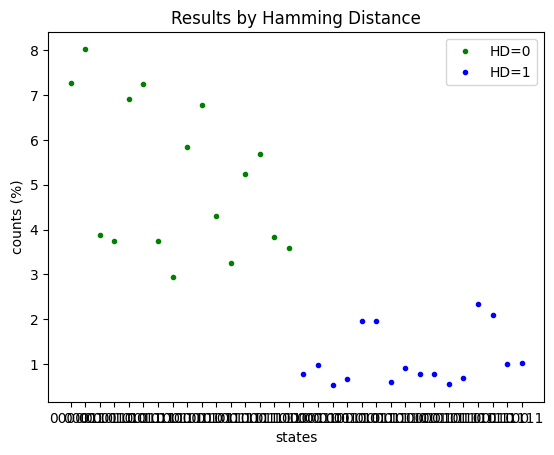

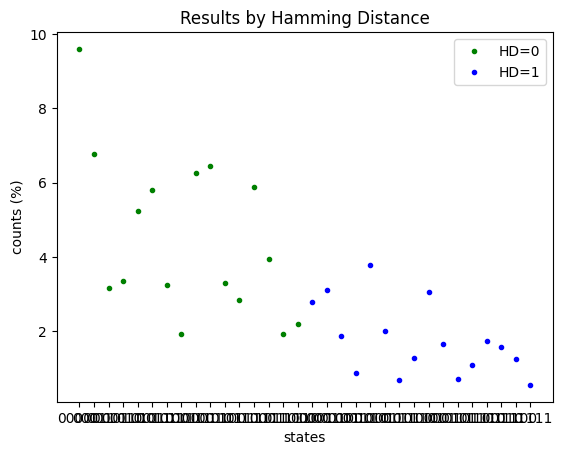

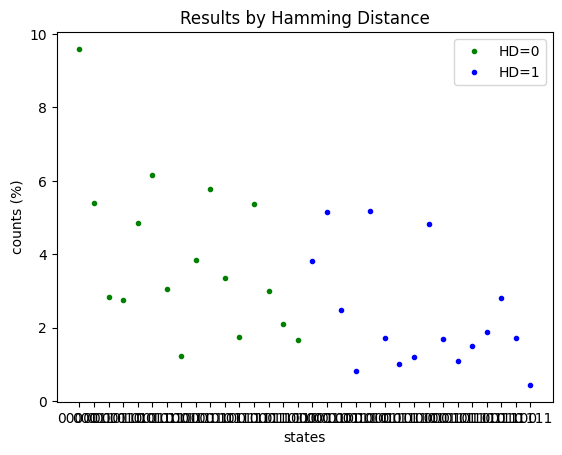

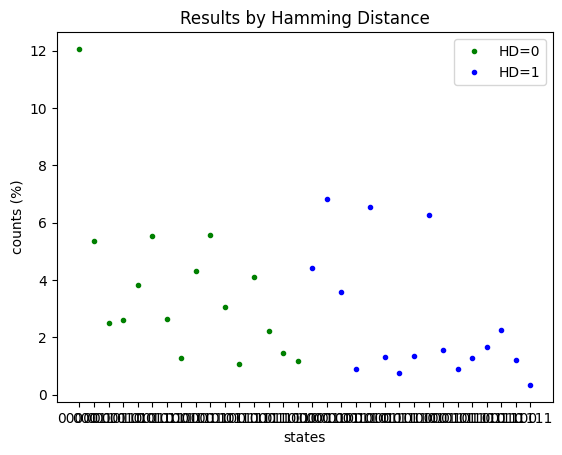

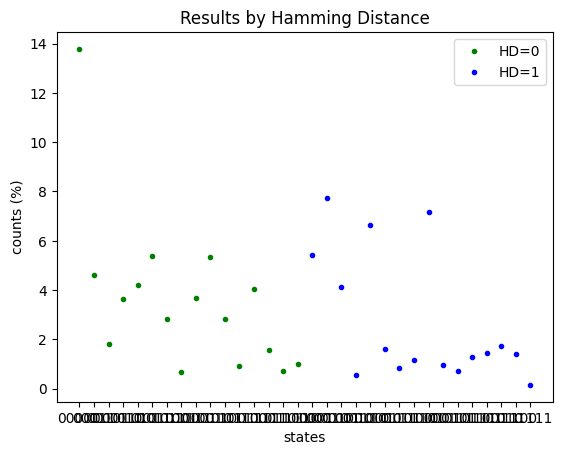

In [43]:
for r in results:
    plot_results_hamming_distance(r, 5, valid_states)

TVD

In [44]:
alpha = generate_uniform_distribution(5, valid_states)


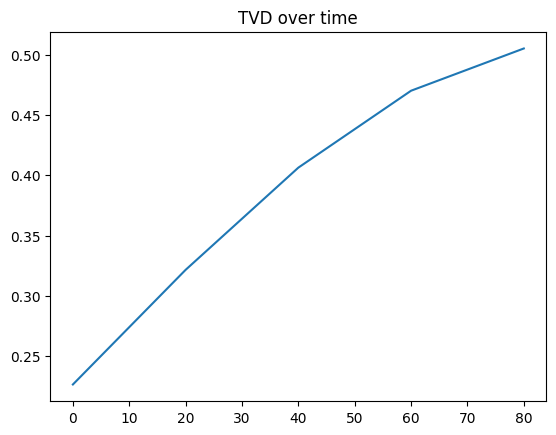

In [45]:
tvd = [calculate_tvd(r, alpha) for r in results]
simple_plot(x, tvd, title="TVD over time")

In [46]:
print(f"best TVD: {round(min(tvd)*100,2)}%")

best TVD: 22.66%


In [47]:
for i in range(len(results)):
    print(delays[i], ':', round(calculate_tvd(results[i], alpha, percentage=True)*100,2))

0 : 22.66
20 : 32.16
40 : 40.62
60 : 47.0
80 : 50.5


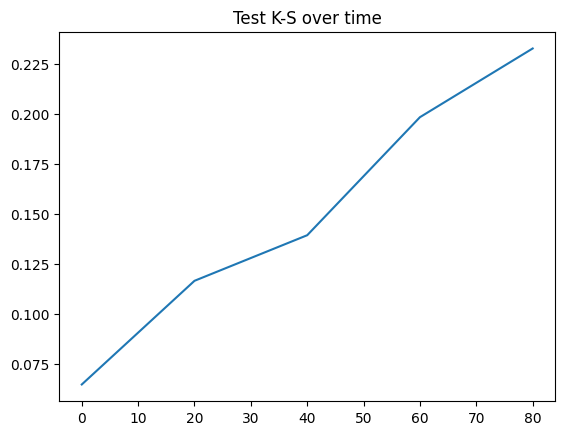

In [48]:
ks = [calculate_test_ks(r, alpha) for r in results]
simple_plot(x, ks, title="Test K-S over time")

In [49]:
print(f"best KS: {round(min(ks)*100,2)}%")

best KS: 6.47%


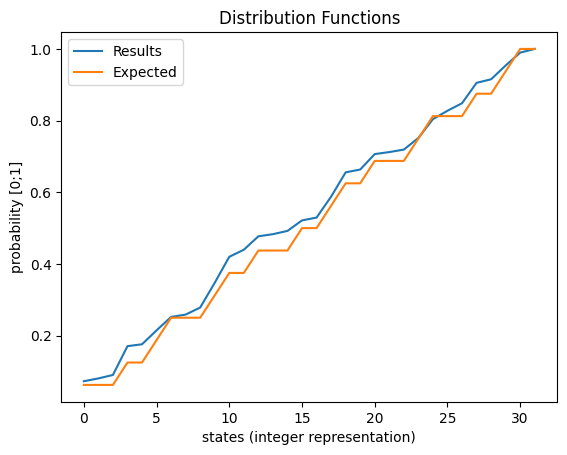

In [50]:
plot_distribution_functions(results[0], alpha)